In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../"))

['proc', 'run', 'var', 'lib', 'tmp', 'mnt', 'root', 'opt', 'boot', 'bin', 'home', 'usr', 'media', 'lib64', 'etc', 'srv', 'dev', 'sys', 'sbin', 'train.csv', 'test.csv', '.dockerenv', 'tools', 'datalab', 'swift', 'tensorflow-1.15.2', 'content', 'dlib-19.18.0-cp36-cp36m-linux_x86_64.whl', 'dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl', 'lib32']


In [4]:
from __future__ import print_function
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io-

df_train = pd.read_csv('../train.csv')
df_test = pd.read_csv('../test.csv')
df = pd.concat([df_train, df_test])
df = df[df['target'] == 0]
print(df.shape)
df.head()

(4342, 5)


,id,keyword,location,text,target
15,23,NaN,NaN,What's up man?,0.0
16,24,NaN,NaN,I love fruits,0.0
17,25,NaN,NaN,Summer is lovely,0.0
18,26,NaN,NaN,My car is so fast,0.0
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0.0


## inspect text

In [0]:
# lowercase all
text = df['text'].str.lower()

we probably want to keep the hashtags, but if there are for example random characters (like links), we want to drop them so they won't affct the precictions

In [6]:
np.random.seed(12345)
np.random.choice(text,10)

array(['i just made a weird high pitched noise and then i heard a siren ofnsixjks ??????',
       'i added a video to a @youtube playlist http://t.co/o7qogmoegu s@x 109 - sws | fatality (captain falcon) vs. snow (fox) ssb4 losers',
       '@wisdc &amp; obama supports  death2usa .. http://t.co/serarcnrby',
       '@hebrooon u better learn derivative of formula seismic rather than thinking about things like that or you are a things like that? haha',
       'ancient mayan tablet found via http://t.co/lmumzkltln http://t.co/yebxxarybf http://t.co/srruqfffr6 http://t.co/cadzxagmsi',
       'i just screamed what the fuck is a hond',
       '@fairx818x @playoverwatch @blizzardcs please blizzard we love you',
       'reddit will now quarantine offensive content: reddit co-founder and ceo steve huffman has unveiled more specif... http://t.co/tdeukjzzii',
       'lhh silent screaming was mastered  https://t.co/biexwdldwc',
       'episcopal priests on road trip with interracial family shares har

In [7]:
print('BEFORE:')
print(text[36])
text = text.map(lambda s: ' '.join([x for x in s.split() if 'http' not in x]))
print('AFTER:')
print(text[36])

BEFORE:
@phdsquares #mufc they've built so much hype around new acquisitions but i doubt they will set the epl ablaze this season.
AFTER:
@phdsquares #mufc they've built so much hype around new acquisitions but i doubt they will set the epl ablaze this season.


any super short tweets?

max tweet len: 157
min tweet len: 5
AxesSubplot(0.125,0.125;0.775x0.755)


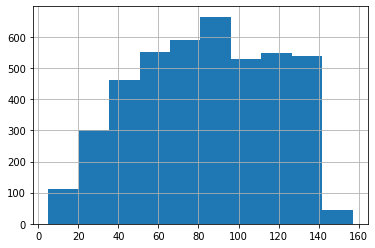

In [8]:
print('max tweet len:',text.map(len).max())
print('min tweet len:',text.map(len).min())
print(text.map(len).hist())

In [9]:
text = text[text.map(len)>60]
len(text)

3122

## Get Chars Dictionary

In [10]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: 88


Inspect Chars

In [11]:
print(chars)

[' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x89', '\x9d', '¡', '¢', '£', '¤', '¨', '©', 'ª', '«', '´', '¼', 'å', 'ç', 'è', 'ê', 'ì', 'ï', 'ò', 'ó', '÷', 'û', 'ü']


maybe last ones are emojis?
Let's take a look at sentences with the weird chars.

In [12]:
for c in chars[-27:]:
    print('\nCHAR:', c)
    smple = [x for x in text if c in x]
    print(random.sample(smple,min(3,len(smple))))


CHAR: {
['{info} baekhyun and suho will be attending the idol sports championship on august 10th cr: syjexo']

CHAR: |
["#pbban (temporary:300) russaky89 @'armageddon | do not kill | flags only | fast xp' for reason", '320 [ir] icemoon [aftershock] | | @djicemoon | #dubstep #trapmusic #dnb #edm #dance #ices\x89û_', 'owner of chicago-area gay bar admits to arson scheme via @theadvocatemag #lgbt |']

CHAR: }
['{info} baekhyun and suho will be attending the idol sports championship on august 10th cr: syjexo', 'å¤} new ladies shoulder tote #handbag faux leather hobo purse cross body bag #womens rt en\x89û_']

CHAR: ~
['the tragedy of life is not that it ends so soon but that we wait so long to begin it. ~ w.m. lewis #quotes', "@himeruisu i'm going to ram your ass so hard i'll have to shove your face on the pillows to muffle your screams of pain and pleasure~", "'i eat because it makes my mouth explode with joy and my soul rise upwards.' ~"]

CHAR: 
['å¤} new ladies shoulder tote #handbag

still weird....
let's remove them

In [0]:
import re
for c in chars[-27:]:
    text = text.str.replace(c,'')

In [14]:
chars = sorted(list(set(''.join(text))))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

print(chars)

total chars: 61
[' ', '!', '#', '$', '%', '&', "'", '(', ')', '*', '+', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?', '@', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Create Input Data
<br>
input - 40 characters of a tweet
<br>
output - next character

In [15]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 1
sentences = []
next_chars = []
for x in text:
    for i in range(0, len(x) - maxlen, step):
        sentences.append(x[i: i + maxlen])
        next_chars.append(x[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 188107


In [16]:
## check example
for i in range(3):
    print(sentences[i],'==>',next_chars[i])

@phdsquares #mufc they've built so much  ==> h
phdsquares #mufc they've built so much h ==> y
hdsquares #mufc they've built so much hy ==> p


In [17]:
text[36]

"@phdsquares #mufc they've built so much hype around new acquisitions but i doubt they will set the epl ablaze this season."

## Vectorization
1. Turn X into matrix of (numer_of_sentences,max_len_of_sentence,num_chars).
<br>
If char i is number j char in sentence k, there will be a 1 in location (k,j,i)
<br>
2. Turn y into a vector of (number_of_sentences,num_chars).
<br>
If character z is the next character in sentence k, there will be a 1 in locaiton (k,z)

In [18]:
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Vectorization...


## build the model: a single LSTM

1. Define we have a sequential model
2. Add an LSTM layer with 128 units. Input shape is a matrix of maxlen characters, where each character is a vector of len(chars)
3. Add a dense layer (fully connected layer) and have the softmax activation pick a winner from the len(chars) possible characters.
4. Pick an optimizer for the network and choose categorical_crossentropy loss function (used in multiclass classification).

In [19]:
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


## Sampler
We don't want the next character to be the one with the highest probaility (we'll get the same results every time).
So we sample with temperature parameter

In [0]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

example of what the function does:

In [21]:
for temperature in [0.1, 0.2, 0.3,  0.5, 1.0, 1.2, 1.3]:
    print(sample([.1,.3,.5,.1],temperature=temperature))

2
2
1
2
2
2
2


We gave the function an array where highest probability was index number 2 (.5).
When temperature was low, we got what we expected.
As we increased the temperature, the function got more creative license choosing the max.
So:
1. temperature helps us not get the same text generated every time
2. low temperature = text similar to trained data
3. high temperature = more creative generation
4. too high temperature = nonsense.

## Generate Text at Epoch End

In [0]:
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print()
    print('----- Generating text after Epoch: %d' % epoch)
    
#     start_index = random.randint(0, len(text) - maxlen - 1)
    tweet = np.random.choice(text) # select random tweet
    start_index = 0

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('----- diversity:', diversity)

        generated = ''
        sentence = tweet[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(120):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

In [23]:
epochs = 5

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/5
188107/188107 [==============================] - 92s 490us/step - loss: 2.7331

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "@potus maybe we should call israel and t"
@potus maybe we should call israel and the the the the to the cour the the the the the the the the the the the the the the the the the the the the the the the c
----- diversity: 0.5
----- Generating with seed: "@potus maybe we should call israel and t"
@potus maybe we should call israel and to the the to mo in bure the si lon or the com it the met rathe sing in the ing in go the the te peo ere hou cor sere co 
----- diversity: 1.0
----- Generating with seed: "@potus maybe we should call israel and t"
@potus maybe we should call israel and thite deail on... f. an'th bere enist it?? targ ace toed uoj t rerk cer; iuns enm aows pack #bhanda loctres wre the ja by
----- diversity: 1.2
----- Generating with seed: "@potus maybe we should call israel and t"
@potus maybe we should

In [24]:
print('Build model...')
model2 = Sequential()
model2.add(LSTM(128, input_shape=(maxlen, len(chars)),return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(128))
model2.add(Dropout(0.2))
model2.add(Dense(len(chars), activation='softmax'))

# optimizer = RMSprop(lr=0.01)
optimizer = Adam()
model2.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model...


In [25]:
epochs = 60

print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

model2.fit(x, y,
          batch_size=128,
          epochs=epochs,
          callbacks=[print_callback])

Epoch 1/60
188107/188107 [==============================] - 172s 915us/step - loss: 2.7540

----- Generating text after Epoch: 0
----- diversity: 0.2
----- Generating with seed: "beware of your temper and a loose tongue"
beware of your temper and a loose tongue the wand the the seat a and the with the deall the deat the and the the and the to the and the from desting the wand th
----- diversity: 0.5
----- Generating with seed: "beware of your temper and a loose tongue"
beware of your temper and a loose tongue to sat wo cat than wand have and way wand siteres inding and wer deal for shows get sturble thar and the arper all the 
----- diversity: 1.0
----- Generating with seed: "beware of your temper and a loose tongue"
beware of your temper and a loose tongueds toutr: curfing &amp; inveres. f1z micta! 5w3 tordide liteas be achose i juis statuli- follerervialad... nousing have 
----- diversity: 1.2
----- Generating with seed: "beware of your temper and a loose tongue"
beware of your tempe

In [0]:
model2.save('model_1.h5')

In [0]:
for diversity in [0.2, 0.5, 1.0, 1.2]:
#     start_index = random.randint(0, len(text) - maxlen - 1)
    with open('model_1_output_with_{}_diversity.txt'.format(diversity), 'a') as f:
        start_index = 0
        f.write('----- diversity:{}\n'.format(diversity))
        for tweet in text:
            generated = ''
            sentence = tweet[start_index: start_index + maxlen]
            generated += sentence
            f.write('----- Generating with seed: "' + sentence + '"\n')
#             f.write(generated)

            for i in range(120):
                x_pred = np.zeros((1, maxlen, len(chars)))
                for t, char in enumerate(sentence):
                    x_pred[0, t, char_indices[char]] = 1.

                preds = model2.predict(x_pred, verbose=0)[0]
                next_index = sample(preds, diversity)
                next_char = indices_char[next_index]

                generated += next_char
                sentence = sentence[1:] + next_char

#                 sys.stdout.write(next_char)
#                 sys.stdout.flush()
            f.write(generated + '\n')
            